# Trends in the Effect of Crosstalk on the MS Gate

## Code Setup

In [1]:
import matplotlib.pyplot as plt
import qutip
from scipy.constants import physical_constants

In [2]:
import importlib
import sys, os
from pathlib import Path
sys.path.append('tools')
import IonChainTools as ict
import MSFidelityEstimation as msfe
importlib.reload(msfe)
from MSFidelityEstimation import *

## Trends in Optical Crosstalk Level

Note: We assume Ytterbium171 ions in a 0.52MHz axial trap. Qualitatively this doesn't change anything important.

In [3]:
M=171*physical_constants['atomic mass constant'][0]
νz = 2*π*0.52*1e6 # 0.52MHz
lengthscale = ict.lengthScale(νz, M=M)

### Ion Positions for Fixed Trap Strength

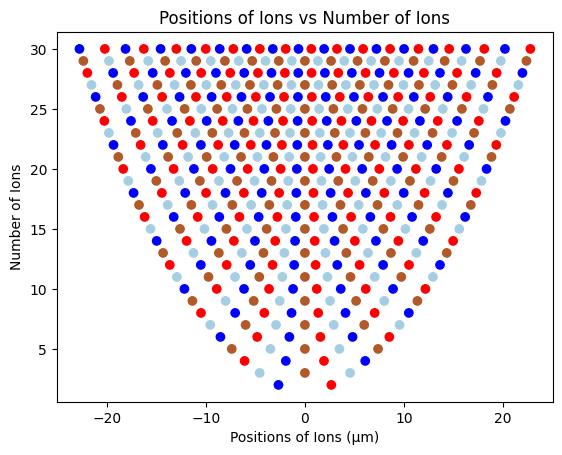

In [4]:
Nrange = range(2, 30+1)
fig, ax = plt.subplots()
for N in Nrange:
    positions = ict.calcPositions(N)*lengthscale*1e6
    c = [(-1)**i for i in range(N)]
    if N%2 == 1:
        c = [(-1)**((N-1)/2-i) for i in range(N)]
        ax.scatter(positions, np.ones(N)*N, c=c, cmap='Paired')
    else:
        c = [(-1)**((N)/2-i) for i in range(N)]
        ax.scatter(positions, np.ones(N)*N, c=c, cmap='bwr')
ax.set_title('Positions of Ions vs Number of Ions')
ax.set_xlabel('Positions of Ions (μm)')
ax.set_ylabel('Number of Ions');

### Minimum Ion Spacing for Fixed Trap Strength

For a fixed trap strength, the distance between the center ions in the string decreases with the number ions.

As per DFV James 1998, the trend is

$$u_{min}(N) = \frac{2.018}{N^{0.559}}$$.

The below numerical calculations match this trend.

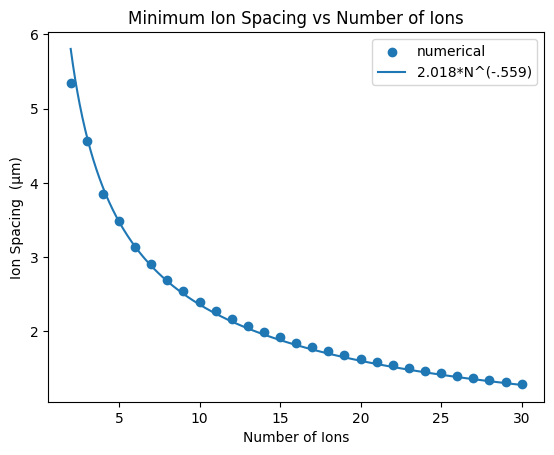

In [5]:
Nrange = range(2, 30+1)
minspacings = []
for N in Nrange:
    p = ict.calcPositions(N)*lengthscale*1e6
    minspacings.append(np.min([p[i]-p[i-1] for i in range(1,N)]))
fig, ax = plt.subplots()
ax.scatter(list(Nrange),minspacings, label="numerical")
ax.plot(np.linspace(2,30,1000), 2.018*np.linspace(2,30,1000)**-0.559*lengthscale*1e6, label="2.018*N^(-.559)")
ax.set_title('Minimum Ion Spacing vs Number of Ions')
ax.set_ylabel('Ion Spacing  (μm)')
ax.set_xlabel('Number of Ions')
ax.legend();

### Radial/Axial Trap Frequency Ratio for Stable String

As the ion string gets longer, we need greater radial trapping strength to keep the string from collapsing into a zig-zag configuration. It seems that requirement follows $\nu_r/\nu_z \sim N$.

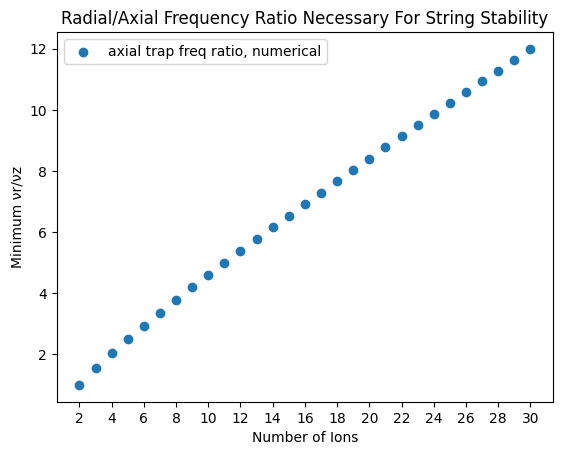

In [6]:
Nrange = range(2, 30+1)
min_radial_freq_ratios = []
for N in Nrange:
    approx_min_ratio = 0
    for stepsize in (10,1,0.1,0.01,0.001):
        for ratio in np.arange(approx_min_ratio, approx_min_ratio+11*stepsize, stepsize):
            #print(N, ratio)
            if len(ict.calcRadialModes(N, νratio=ratio)) == N:
                #print('over')
                approx_min_ratio = ratio-stepsize
                break
    approx_min_ratio += 0.0001
    min_radial_freq_ratios.append(approx_min_ratio)

fig, ax = plt.subplots()
ax.scatter(list(Nrange),min_radial_freq_ratios, label="axial trap freq ratio, numerical")
ax.set_title('Radial/Axial Frequency Ratio Necessary For String Stability')
ax.set_ylabel('Minimum νr/νz')
ax.set_xlabel('Number of Ions')
ax.set_xticks(np.arange(2,30+1,2))
ax.legend();

### Trap Frequency to Keep Constant Minimum Spacing

If we have more ions, we must decrease the axial trap strength to stop the minimum ion spacing from decreasing. It turns out that this decrease in axial trap strength is roughly enough to maintain the ratio between radial and axial trap strength necessary for a stable string. This makes some sense since if we decrease axial trapping strength to maintain minimum ion spacing we are simultaneously ensuring that no ions are being squeezed by their neighbors enough to pop out of line.

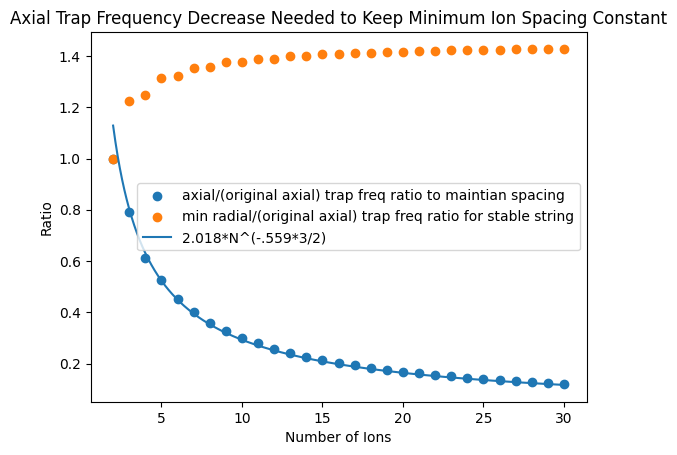

In [7]:
Nrange = range(2, 30+1)
necessary_axialfreq_fracs = []
targetspacing = 0
for N in Nrange:
    p = ict.calcPositions(N)*lengthscale*1e6
    minspacing = np.min([p[i]-p[i-1] for i in range(1,N)])
    if N==2: targetspacing = minspacing
    desired_lengthscale_factor = targetspacing/minspacing
    necessary_axialfreq_fracs.append(desired_lengthscale_factor**(-3/2)) # Since lengthscale ~ νz^(-2/3)
necessary_axialfreq_fracs = np.array(necessary_axialfreq_fracs)
min_radial_freq_ratios = np.array(min_radial_freq_ratios)
fig, ax = plt.subplots()
ax.scatter(list(Nrange),necessary_axialfreq_fracs, label="axial/(original axial) trap freq ratio to maintian spacing")
ax.scatter(list(Nrange),necessary_axialfreq_fracs*min_radial_freq_ratios, label="min radial/(original axial) trap freq ratio for stable string")
ax.plot(np.linspace(2,30,1000), 2.018*np.linspace(2,30,1000)**(-0.559*3/2), label="2.018*N^(-.559*3/2)")
ax.set_title('Axial Trap Frequency Decrease Needed to Keep Minimum Ion Spacing Constant')
ax.set_ylabel('Ratio')
ax.set_xlabel('Number of Ions')
ax.legend();

### Ion Positions when Axial Frequency is Adjusted for Constant Minimum Spacing

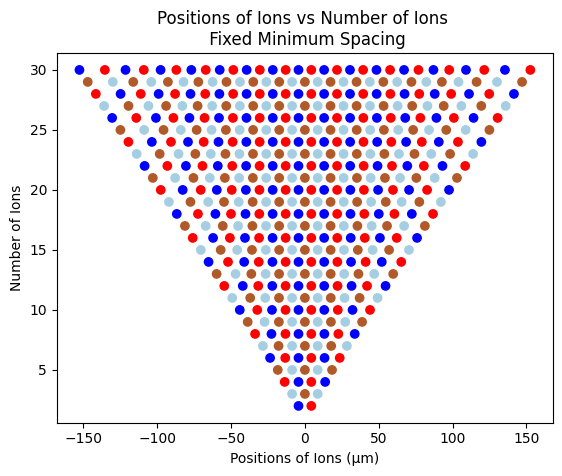

In [8]:
Nrange = range(2, 30+1)
fig, ax = plt.subplots()
for N in Nrange:
    positions = ict.calcPositions(N)*ict.lengthScale(νz*necessary_axialfreq_fracs[N-2])*1e6
    c = [(-1)**i for i in range(N)]
    if N%2 == 1:
        c = [(-1)**((N-1)/2-i) for i in range(N)]
        ax.scatter(positions, np.ones(N)*N, c=c, cmap='Paired')
    else:
        c = [(-1)**((N)/2-i) for i in range(N)]
        ax.scatter(positions, np.ones(N)*N, c=c, cmap='bwr')
ax.set_title('Positions of Ions vs Number of Ions \n Fixed Minimum Spacing')
ax.set_xlabel('Positions of Ions (μm)')
ax.set_ylabel('Number of Ions');

In [16]:
min_radial_freq_ratios

array([ 1.0001,  1.5491,  2.0381,  2.4971,  2.9381,  3.3651,  3.7831,
        4.1921,  4.5951,  4.9931,  5.3851,  5.7731,  6.1581,  6.5391,
        6.9171,  7.2931,  7.6651,  8.0361,  8.4041,  8.7701,  9.1351,
        9.4971,  9.8581, 10.2171, 10.5751, 10.9311, 11.2861, 11.6401,
       11.9931])

In [24]:
min_radial_freq_ratios

array([ 1.0001,  1.5491,  2.0381,  2.4971,  2.9381,  3.3651,  3.7831,
        4.1921,  4.5951,  4.9931,  5.3851,  5.7731,  6.1581,  6.5391,
        6.9171,  7.2931,  7.6651,  8.0361,  8.4041,  8.7701,  9.1351,
        9.4971,  9.8581, 10.2171, 10.5751, 10.9311, 11.2861, 11.6401,
       11.9931])

Text(0.5, 1.0, 'Minimum Radial Mode Freq Spacing when Trap Freqs Adjusted for Equal Ion Spacing')

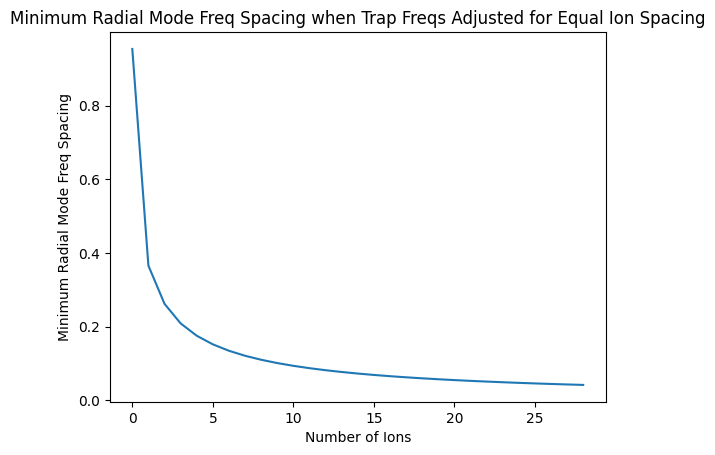

In [34]:
necessary_axialfreq_fracs
min_radial_freq_ratios
min_rad_freq_spacings = []
for N in range(2, 30+1):
    axfreq = necessary_axialfreq_fracs[N-2]
    radfreq = axfreq*min_radial_freq_ratios[N-2]
    modes = ict.calcRadialModes(N, νratio=radfreq/axfreq+0.001)
    min_rad_freq_spacing =min([modes[i+1][0]-modes[i][0] for i in range(N-1)])
    min_rad_freq_spacings.append(min_rad_freq_spacing)
plt.plot(min_rad_freq_spacings)
plt.xlabel("Number of Ions")
plt.ylabel("Minimum Radial Mode Freq Spacing")
plt.title("Minimum Radial Mode Freq Spacing when Trap Freqs Adjusted for Equal Ion Spacing")

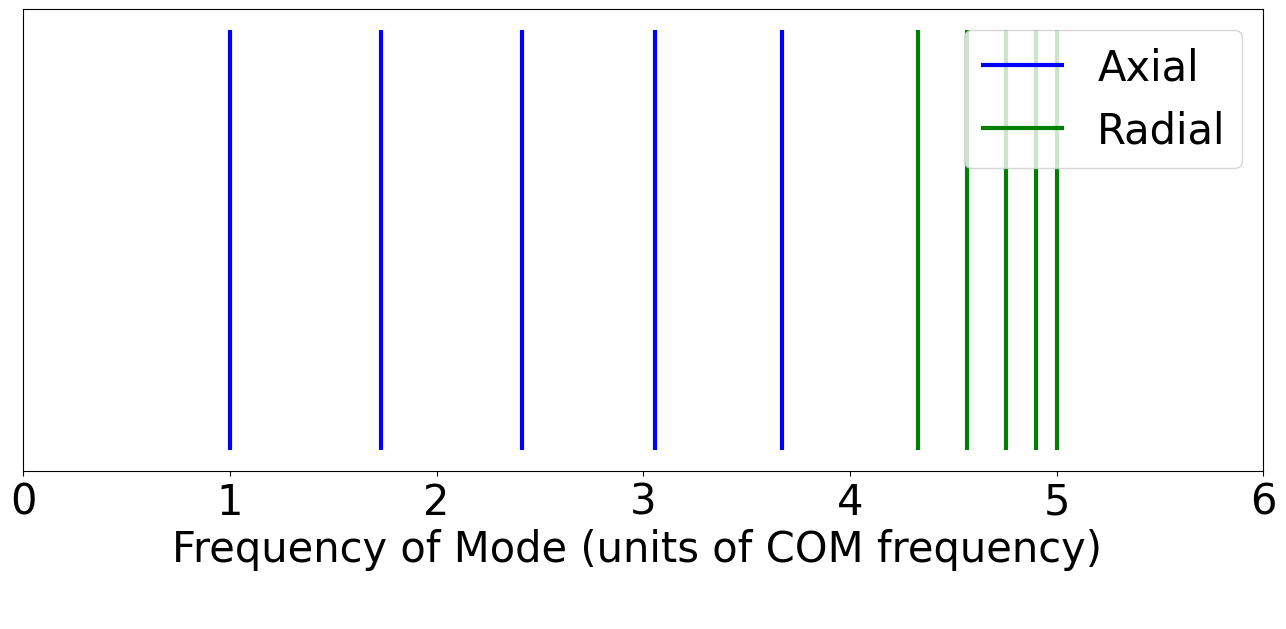

In [47]:
N=5
axialmodes = ict.calcAxialModes(N)
radialmodes = ict.calcRadialModes(N, νratio=5)
axialfreqs = [axialmodes[m][0] for m in range(N)]
radialfreqs = [radialmodes[m][0] for m in range(N)]
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(0, 6)
ax.get_yaxis().set_visible(False)
ax.vlines(axialfreqs, ymin=0, ymax=1, label="Axial", color="blue", lw=3)
ax.vlines(radialfreqs, ymin=0, ymax=1, label="Radial", color="green", lw=3)
ax.set_xlabel("Frequency of Mode (units of COM frequency) \n"r"", fontsize=30)
ax.legend(fontsize=30)
ax.tick_params(labelsize=30)

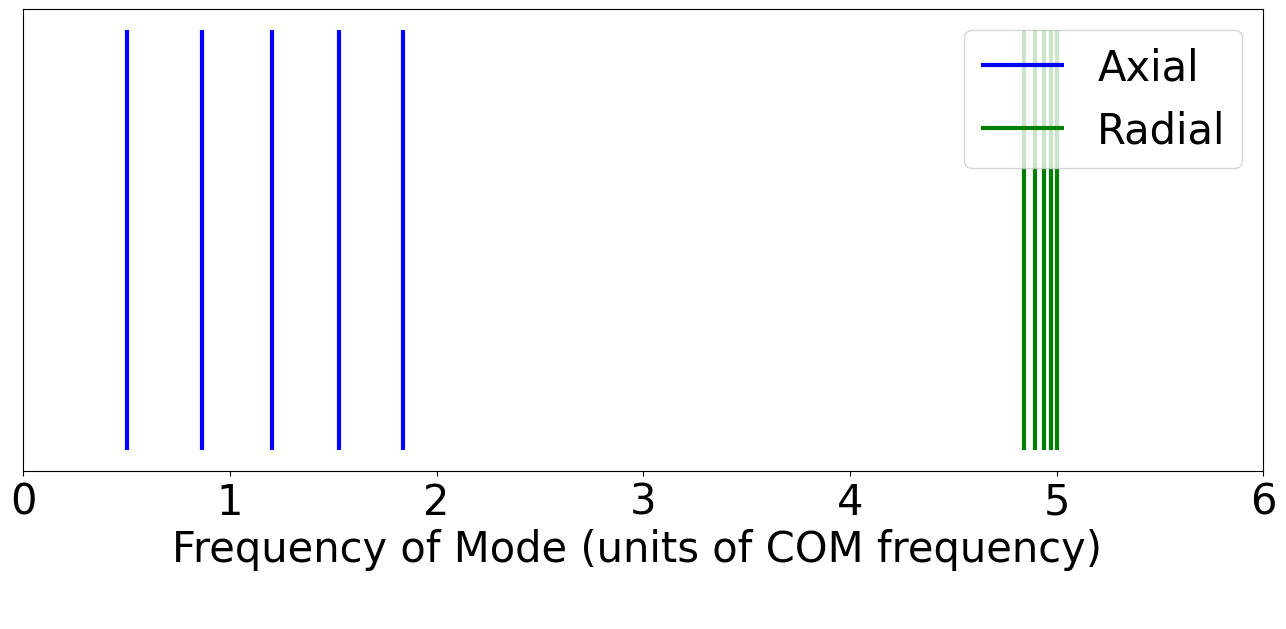

In [46]:
N=5
axialmodes = ict.calcAxialModes(N)
radialmodes = ict.calcRadialModes(N, νratio=10)
axialfreqs = [axialmodes[m][0]/2 for m in range(N)]
radialfreqs = [radialmodes[m][0]/2 for m in range(N)]
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(0, 6)
ax.get_yaxis().set_visible(False)
ax.vlines(axialfreqs, ymin=0, ymax=1, label="Axial", color="blue", lw=3)
ax.vlines(radialfreqs, ymin=0, ymax=1, label="Radial", color="green", lw=3)
ax.set_xlabel("Frequency of Mode (units of COM frequency) \n"r"", fontsize=30)
ax.legend(fontsize=30)
ax.tick_params(labelsize=30)

## Trends in MS Fidelities

### MS Fidelity Calculation

Physical values are taken from QSCOUT papers.

In [9]:
# Ytterbium171
M=171*physical_constants['atomic mass constant'][0]

# Laser wavelength
# carrier_wavelen = # 355*1e-9 # 355nm, from "frequency robust ..." paper
# carrier_wavenum = 2*π/carrier_wavelen # Laser wavenumber (k)
# carrier_freq = scipy.constants.c*carrier_wavenum
qbit_splitting = 2*π*12.643*1e6 # qubit splitting, from "Engineering The ..." paper
raman_wavelen = 355*1e-9 # 355nm, from "frequency robust ..." paper
raman_freq = 2*π*scipy.constants.c/raman_wavelen
kvec = qbit_splitting/scipy.constants.c*np.sqrt(2)

# Rabi rate
Ωpeak = 2*π*190*1e3 # 190MHz, quoted in "Frequency-robust MS ..." paper

# Gate duration
τ = 200e-6 # 200μs, from "Frequency-robust MS ..." paper

# Trap specifications
# Axial COM of 0.52MHz and highest radial mode of 2.296MHz are quoted in 
# "Frequency-robust Mølmer-Sørensen gates via balanced contributions of multiple motional modes"
νz = 2*π*0.52*1e6 # 0.52MHz
νr = 2*π*2.296*1e6 # 2.296MHz

# Blue and Red beam phases
# Below should implement X gate
ϕB = π/2
ϕR = π/2

# Optical Crosstalk, from "ENGINEERING THE QUANTUM SCIENTIFIC COMPUTING OPEN USER TESTBED"
# These values are scaled such that Ω=1 for the target ion
neighΩ = 0.0236 # Rabi frequency on neighbor of target ion
nneighΩ = 0.006 # Rabi frequency on next neighbor of target ion

In [10]:
def Ωvals_from_lorentzian_profile(N, targets, axialfreq, fwhm=2e-6):
    positions = ict.calcPositions(N)*ict.lengthScale(axialfreq, M=M)
    beamcenters = [positions[t] for t in targets]
    Ωvals = sum([np.array([1/(((p-c)/(fwhm/2))**2+1) for p in positions]) for c in beamcenters])
    Ωvals[Ωvals<0.001] = 0
    return Ωvals

In [19]:
def calcFidelity(N, m, targets, opticalxtalk='None', fixspacing=False, modextalk=True, νratio=None):
    modetype='radial'
    K=1 # Only 1 loop in phase space
    adjustedνz = necessary_axialfreq_fracs[N-2]*νz if fixspacing == True else νz
    adjustedνr = νz*νratio if νratio != None else νr
    trapspec = TrapSpec(adjustedνz, adjustedνr)
    devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    if opticalxtalk == "fixed":
        Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ, nneighΩ)
    elif opticalxtalk == "lorentzian":
        Ωvals = Ω*Ωvals_from_lorentzian_profile(N, targets, adjustedνz)
    elif opticalxtalk == "none":
        Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, 0, 0)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    simmodes = list(range(N)) if modextalk==True else [m]
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=simmodes,modetype=modetype, modetrunc=2)
    fidions = targets
    illuminated = [i for i in range(N) if Ωvals[i]!=0]
    traceindices = [illuminated.index(i) for i in fidions]
    ρred = ρf.ptrace(traceindices)
    parity_curve_amplitude = 2*abs(ρred[3,0])
    pop00 = abs(ρred[0,0])
    pop11 = abs(ρred[3,3])
    fid = (pop00 + pop11 + abs(2*ρred[3,0].imag))/2
    return fid

### MS Fidelities with only Mode Crosstalk (No Optical Crosstalk)

For a fixed $\nu_r/\nu_z$, mode crosstalk degrades MS fidelity with increasing N, but not super quickly.

Text(0.5, 0, '$N$')

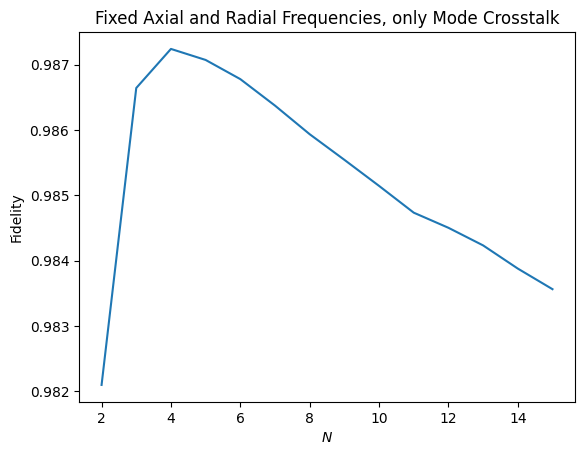

In [12]:
maxN = 15
avgfidsCOM = []
for N in range(2, maxN+1):
    m = N-1 # COM mode
    fids = []
    for targets in itertools.combinations(range(N),2):
        fids.append(calcFidelity(N, m, targets, opticalxtalk='none', fixspacing=False, modextalk=True, νratio=9))
    avgfidsCOM.append(np.average(fids))
plt.plot(list(range(2,maxN+1)), avgfidsCOM)
plt.title("Fixed Axial and Radial Frequencies, only Mode Crosstalk")
plt.ylabel("Fidelity")
plt.xlabel("$N$")

If $\nu_z$ is lowered for higher $N$ such that minimum ion spacing is kept constant, mode crosstalk effects rapidly degrade MS fidelity. This is because lowering $\nu_z$ both (1) scales the radial mode frequencies, decreasing their distance, and (2) increases $\nu_r/\nu_z$, which squishes the radial modes closer to each other.

Text(0.5, 0, '$N$')

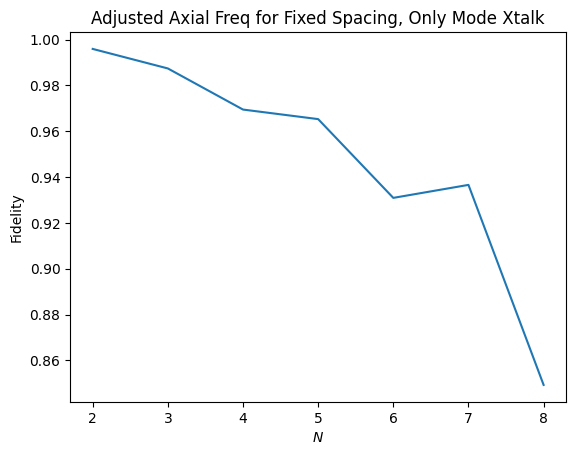

In [13]:
maxN = 8
avgfidsCOM = []
for N in range(2, maxN+1):
    m = N-1 # COM mode
    fids = []
    for targets in itertools.combinations(range(N),2):
        fids.append(calcFidelity(N, m, targets, opticalxtalk='none', fixspacing=True, modextalk=True))
    avgfidsCOM.append(np.average(fids))
plt.plot(list(range(2,maxN+1)), avgfidsCOM)
plt.title("Adjusted Axial Freq for Fixed Spacing, Only Mode Xtalk")
plt.ylabel("Fidelity")
plt.xlabel("$N$")

For an illustration of the effect of $\nu_r/\nu_z$, consider the mode structure for 4 ions with $\nu_r/\nu_z=4$ vs $\nu_r/\nu_z=8$.

Text(0.5, 0, 'Frequency (units of $\\nu_z$)')

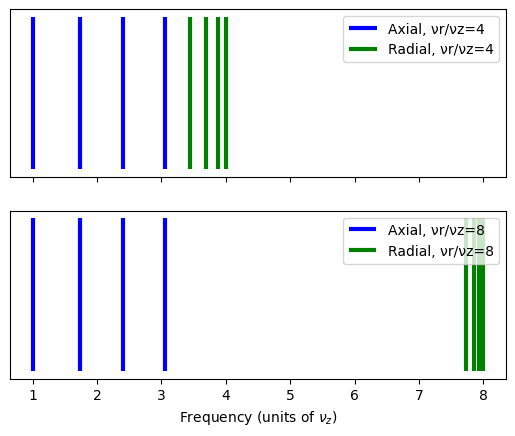

In [14]:
N=4
fig, axes = plt.subplots(2,1, sharex=True)
for ax, νratio in zip(axes,(4,8)):
    axial_freqs = [mode[0] for mode in ict.calcAxialModes(N)]
    radial_freqs = [mode[0] for mode in ict.calcRadialModes(N, νratio=νratio)]
    ax.vlines(axial_freqs, ymin=0, ymax=1, label=f"Axial, νr/νz={νratio}", color="blue", lw=3)
    ax.vlines(radial_freqs, ymin=0, ymax=1, label=f"Radial, νr/νz={νratio}", color="green", lw=3)
    ax.legend()
    ax.get_yaxis().set_visible(False)
ax.set_xlabel(r"Frequency (units of $\nu_z$)")

Text(0.5, 0, '$N$')

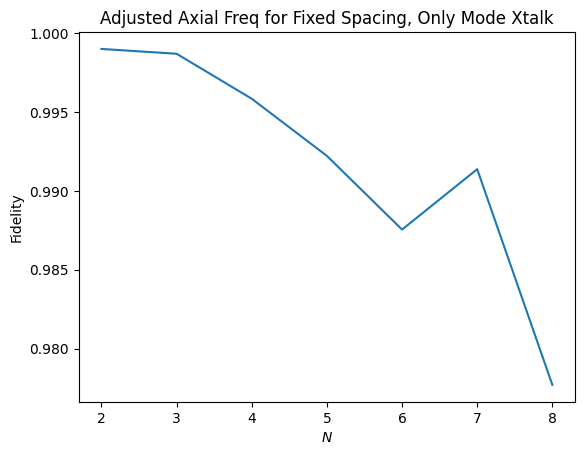

In [21]:
maxN = 8
avgfidsCOM = []
for N in range(2, maxN+1):
    m = N-1 # COM mode
    fids = []
    for targets in itertools.combinations(range(N),2):
        fids.append(calcFidelity(N, m, targets, opticalxtalk='none', fixspacing=True, modextalk=True, νratio=1.43))
    avgfidsCOM.append(np.average(fids))
plt.plot(list(range(2,maxN+1)), avgfidsCOM)
plt.title("Adjusted Axial Freq for Fixed Spacing, Only Mode Xtalk")
plt.ylabel("Fidelity")
plt.xlabel("$N$")

### MS Fidelities with Fixed Optical Crosstalk
Crosstalk is 2.36% neighbor, 0.62% next neighbor (QSCOUT vals).

Modes are counted in the order for radial modes (COM last).

#### Average for COM Mode, Fixed Optical Crosstalk, No Mode Crosstalk

If we only consider COM mode gates and don't account for mode crosstalk, the error due to fixed optical crosstalk hits a max. This is because once $N$ is large enough, the average MS gate fidelity is dominated by gates that are between two target ions in different parts of the string, each with optical crosstalk-affected neighbors on either side, and all ions having the same coupling to the mode. Such situations are basically independent of $N$, hence the flattening out of the fidelity curve.

Text(0.5, 0, '$N$')

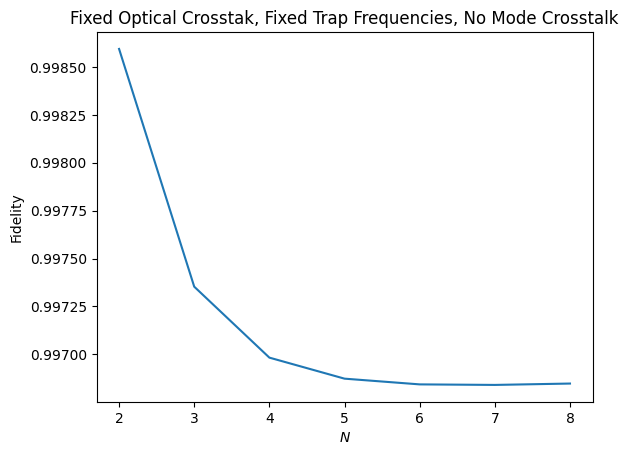

In [15]:
avgfidsCOM = []
maxN = 8
for N in range(2, maxN+1):
    m = N-1 # COM mode
    fids = []
    for targets in itertools.combinations(range(N),2):
        fids.append(calcFidelity(N, m, targets, opticalxtalk='fixed', fixspacing=False, modextalk=False))
    avgfidsCOM.append(np.average(fids))
plt.plot(list(range(2,maxN+1)), avgfidsCOM)
plt.title("Fixed Optical Crosstak, Fixed Trap Frequencies, No Mode Crosstalk")
plt.ylabel("Fidelity")
plt.xlabel("$N$")

#### Average for COM Mode, Fixed Optical Crosstalk, with Mode Crosstalk

If we add in mode crosstalk, fidelity no longer flattens out.

Text(0.5, 0, '$N$')

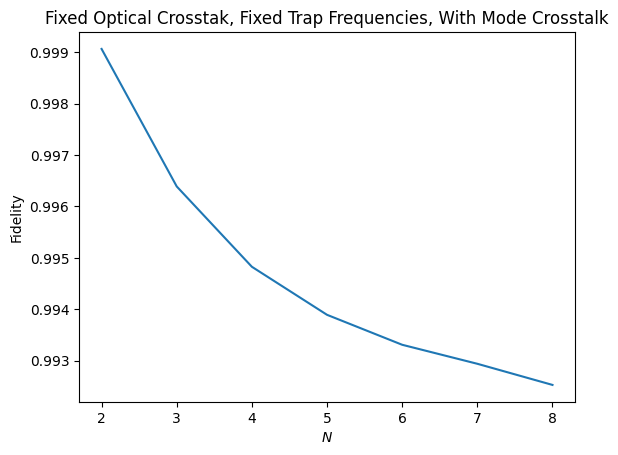

In [16]:
avgfidsCOM = []
maxN = 8
for N in range(2, maxN+1):
    m = N-1 # COM mode
    fids = []
    for targets in itertools.combinations(range(N),2):
        fids.append(calcFidelity(N, m, targets, opticalxtalk='fixed', fixspacing=False, modextalk=True))
    avgfidsCOM.append(np.average(fids))
plt.plot(list(range(2,maxN+1)), avgfidsCOM)
plt.title("Fixed Optical Crosstak, Fixed Trap Frequencies, With Mode Crosstalk")
plt.ylabel("Fidelity")
plt.xlabel("$N$")

### MS Fidelities with Optical Crosstalk, Fixed Minimum Ion Spacing

Fixing minimum ion spacing and using an optical crosstalk profile that is dependent on distance is similar to using fixed crosstalk: the average error in MS gates does not increase with $N$. (So long as we ignore the increase in mode crosstalk due to decreasing $\nu_z$.)

Text(0.5, 0, '$N$')

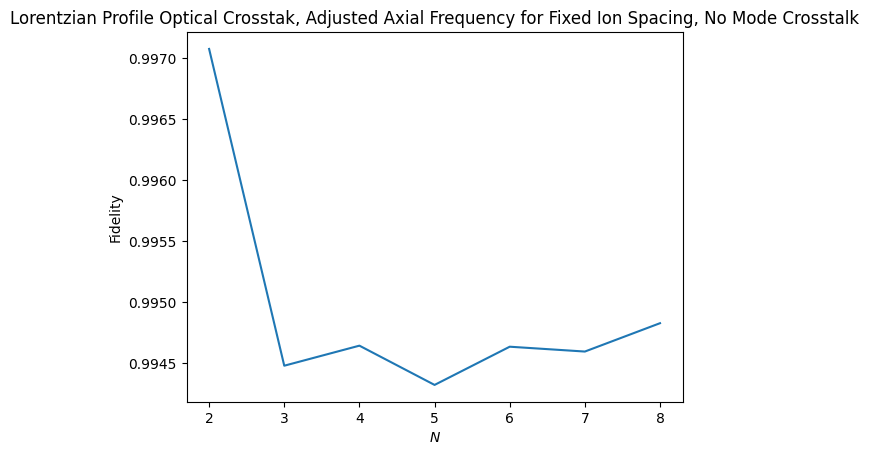

In [17]:
avgfidsCOM = []
maxN = 8
for N in range(2, maxN+1):
    m = N-1 # COM mode
    fids = []
    for targets in itertools.combinations(range(N),2):
        fids.append(calcFidelity(N, m, targets, opticalxtalk='lorentzian', fixspacing=True, modextalk=False))
    avgfidsCOM.append(np.average(fids))
plt.plot(list(range(2,maxN+1)), avgfidsCOM)
plt.title("Lorentzian Profile Optical Crosstak, Adjusted Axial Frequency for Fixed Ion Spacing, No Mode Crosstalk")
plt.ylabel("Fidelity")
plt.xlabel("$N$")

### MS Fidelities with Optical Crosstalk, Fixed Axial Frequency

If we fix axial frequency, the ions get closer together as $N$ increases and so optical crosstalk error increases.

Text(0.5, 0, '$N$')

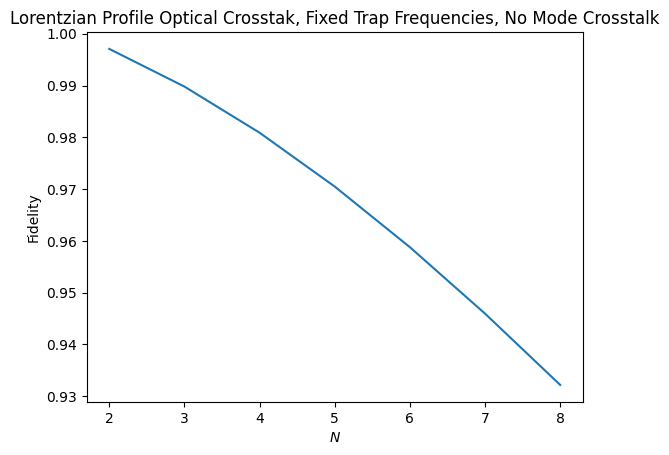

In [18]:
avgfidsCOM = []
maxN = 8
for N in range(2, maxN+1):
    m = N-1 # COM mode
    fids = []
    for targets in itertools.combinations(range(N),2):
        fids.append(calcFidelity(N, m, targets, opticalxtalk='lorentzian', fixspacing=False, modextalk=False))
    avgfidsCOM.append(np.average(fids))
plt.plot(list(range(2,maxN+1)), avgfidsCOM)
plt.title("Lorentzian Profile Optical Crosstak, Fixed Trap Frequencies, No Mode Crosstalk")
plt.ylabel("Fidelity")
plt.xlabel("$N$")